
__Продакт вернул нам такой дизайн эксперимента:__

*1. `Бизнес-проблема:`* мы считаем, что конверсии из визита в покупку в нашем магазине недостаточно высоки. Мы посмотрели на страницы конкурентов и поняли, что у нас есть возможность увеличить объем продаж, если мы еще немного изменим дизайн страницы с каталогом продукции. 

*2. `Гипотеза:`* предполагается, что добавление видео с процессом приготовления вкусностей мотивирует к их покупке и позволяет добиться двух эффектов:
   * повышение конверсии из визита в оплату (больше людей захотят купить нашу продукцию)
   * как минимум, не снижение среднего чека покупки, а в идеале — увеличение
    
*3. `Ожидаемые действия пользователей:`* мы ожидаем, что, увидев видео с процессом приготовления вкусностей вместе с описанием продукции, больше людей захотят сделать покупку, а возможно — в среднем будут покупать больше продукции в одном заказе.

*4. `Эксперимент будет считаться успешным, если:`*
   * конверсия из визита в покупку с окном в 7 дней повысится
   * средний чек покупки не снизится


## Что нужно сделать?

Проанализировать данные нового теста и дать свои комментарии о его успешности. Можно ли выкатывать изменение на всех пользователей?

1. Выбрать окно конверсии
2. Исследовать распределение пользователей по группам по основным сегментам
3. Оценить статистическую значимость в изменении конверсии с помощью критерия хи-квадрат
4. Вычислить мощность теста
5. Использовать бутстрап для оценки влияния теста на средний чек
6. Сделать вывод по результатам проведенного теста 

### Выбераем окно конверсии, используя исторические данные 



In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

In [3]:
historical_data = pd.read_csv('investigate_window.csv', parse_dates = [2,3], index_col = 0)

In [4]:
historical_data

,user_id,main_page_viewed_at,order_completed_at,time_to_order
0,959238,2020-11-20 23:55:02.759000+00:00,2020-11-30 02:22:32.759000+00:00,9.102431
1,337366,2020-12-05 23:41:42.244000+00:00,2020-12-12 22:25:52.244000+00:00,6.947338
2,259956,2020-11-20 23:33:53.269000+00:00,2020-11-25 13:08:03.269000+00:00,4.565394
3,534280,2020-11-28 23:44:56.556000+00:00,2020-12-05 10:14:06.556000+00:00,6.436921
4,795121,2020-11-18 23:59:56.236000+00:00,2020-11-27 02:38:16.236000+00:00,8.109954
...,...,...,...,...
9995,240447,2020-11-17 10:06:55.769000+00:00,2020-11-20 12:10:57.435667+00:00,3.086130
9996,862060,2020-11-17 12:06:56.864000+00:00,2020-11-20 14:24:35.197333+00:00,3.095583
9997,798767,2020-11-18 08:55:35.282000+00:00,2020-11-21 11:33:38.615333+00:00,3.109761
9998,967650,2020-11-17 08:13:14.589000+00:00,2020-11-20 12:33:22.922333+00:00,3.180652


In [5]:
historical_data.dtypes

user_id                              int64
main_page_viewed_at    datetime64[ns, UTC]
order_completed_at     datetime64[ns, UTC]
time_to_order                      float64
dtype: object

### Вычисляем 95, 90 и 85 перцентили для наших данных


In [6]:
import numpy as np

In [7]:
np.percentile(historical_data['time_to_order'], 100)

14.263310185185183

In [8]:
np.percentile(historical_data['time_to_order'], 95) #95 перцетиль соответствует недельному окну конверсии

7.117476851851854

In [9]:
np.percentile(historical_data['time_to_order'], 90)

2.864949845679016

In [10]:
np.percentile(historical_data['time_to_order'], 85)

1.9903886959876524

In [11]:
perc_95 = round(np.percentile(historical_data['time_to_order'], 95),1)
perc_95

7.1

### Строим гистограмму распределения времени между первым заходом на сайт и покупкой.
 

In [12]:
import seaborn as sns 
import matplotlib.pyplot as plt

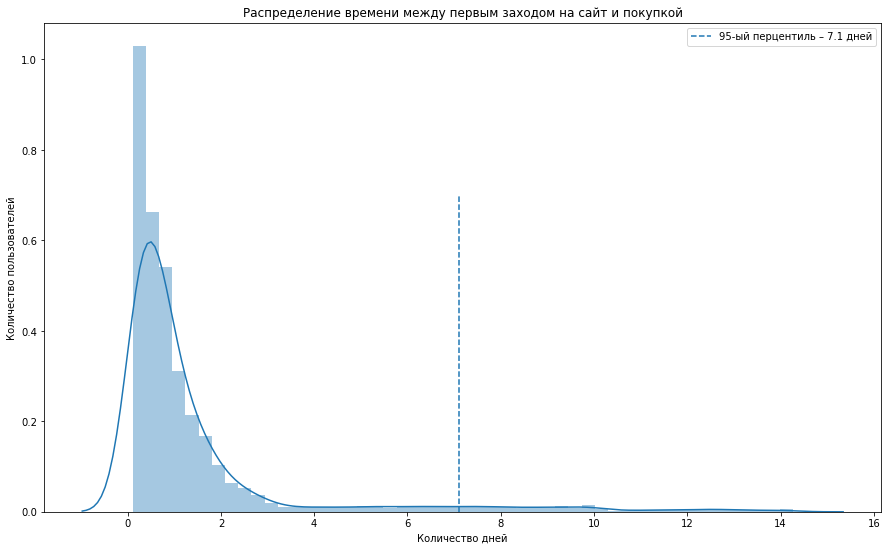

In [13]:
plt.figure (figsize=(15,9))

sns.distplot(historical_data['time_to_order'])

plt.vlines(perc_95, 
           ymin = 0, 
           ymax = 0.7, 
           linestyles = 'dashed', 
           label = f'95-ый перцентиль – {perc_95} дней')

plt.title('Распределение времени между первым заходом на сайт и покупкой')
plt.xlabel('Количество дней')
plt.ylabel('Количество пользователей')

plt.legend()

plt.show()


##  Исследуем распределение пользователей по группам по основным сегментам 


In [14]:
data = pd.read_csv('bakery_ab_test.csv', index_col = 0)
data

,user_id,test_group,purchase_amount,geo_group,acquisition_channel,within_window,platform
1,3738,test,306.639511,regions,target_direct,1,pc
2,3755,control,NaN,regions,target_direct,0,pc
3,3772,test,NaN,regions,context_brand,0,mobile
4,3789,control,NaN,spb,target_direct,0,pc
5,3806,test,NaN,regions,social_media,0,pc
...,...,...,...,...,...,...,...
152995,2604636,test,NaN,regions,target_direct,0,pc
152996,2604653,control,5236.818309,regions,organic,1,mobile
152997,2604670,control,NaN,regions,target_direct,0,pc
152998,2604687,control,101.783032,regions,target_direct,1,pc


### Проверяем пользователей по сегментам внутри каждой группы. 

In [15]:
def plot_segments_distribution(df, segment_columns, test_factor):
    for segment in segment_columns:
        aggregated_data = df.groupby(by = [test_factor, segment])['user_id'].count().reset_index()
        sns.catplot(x = segment, 
                    y = 'user_id', 
                    hue = test_factor, 
                    data = aggregated_data, 
                    kind = "bar", 
                    height = 4, 
                    aspect = 1.5) 

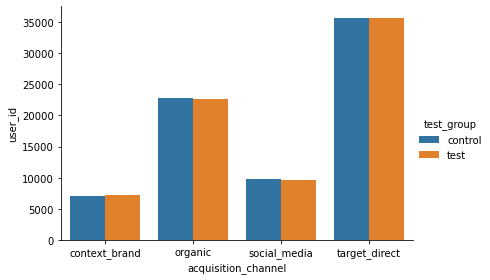

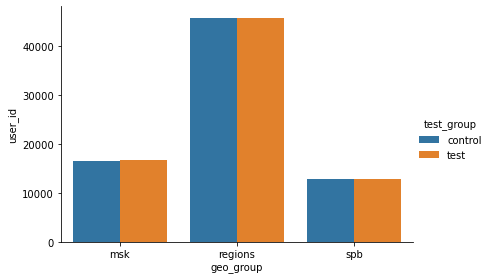

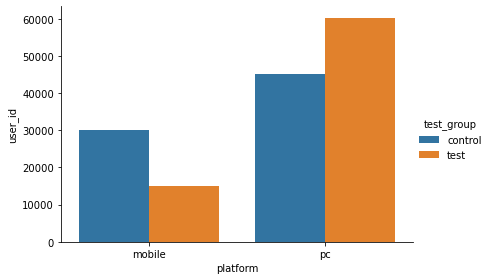

In [16]:
plot_segments_distribution (data, ["acquisition_channel", "geo_group", "platform"], "test_group")

## Используем критерий Хи-квадрат для конверсии


будем анализировать параллельно 3 теста:

1. Все пользователи, попавшие в тест
2. Пользователи, заходившие с ПК `platform = 'pc'`
3. Пользователи, заходившие с мобильного `platform = 'mobile'`

**Создаем для каждой из 3 групп теста отдельную таблицу с метриками**
   - общее количество пользователей 
   - количество покупок в окне конверсии
   - средняя сумма покупки 
   - конверсия


In [17]:
metrics = data.groupby('test_group', as_index= False).agg({'user_id':'count', 'within_window':'sum', 'purchase_amount':'mean' })
metrics['conversion'] = round(metrics['within_window']/metrics['user_id']*100, 2)
metrics

,test_group,user_id,within_window,purchase_amount,conversion
0,control,75210,22998,5170.864335,30.58
1,test,75273,24427,5394.771589,32.45


In [18]:
metrics_pc = data.loc[data['platform']=='pc'].groupby('test_group', as_index= False).agg({'user_id':'count', 'within_window':'sum', 'purchase_amount':'mean' })
metrics_pc['conversion'] = round(metrics_pc['within_window']/metrics_pc['user_id']*100, 2)
metrics_pc

,test_group,user_id,within_window,purchase_amount,conversion
0,control,45112,13732,5200.121803,30.44
1,test,60317,19659,5401.003720,32.59


In [19]:
metrics_mobile = metrics_mobile = data.loc[data['platform']=='mobile'].groupby('test_group', as_index= False).agg({'user_id':'count', 'within_window':'sum', 'purchase_amount':'mean' })
metrics_mobile['conversion'] = round(metrics_mobile['within_window']/metrics_mobile['user_id']*100, 2)
metrics_mobile

,test_group,user_id,within_window,purchase_amount,conversion
0,control,30098,9266,5127.505438,30.79
1,test,14956,4768,5369.075812,31.88


### Вычисляем `p-value` **для каждой группы с помощью теста хи-квадрат**



In [20]:
import statsmodels.stats.proportion as proportion

In [21]:
chi2stat, pval, table = proportion.proportions_chisquare(metrics['within_window'], metrics['user_id'])
pval

5.321539863368111e-15

In [22]:
chi2stat_pc, pval_pc, table_pc = proportion.proportions_chisquare(metrics_pc['within_window'], metrics_pc['user_id'])
pval_pc

1.0436637877855105e-13

In [23]:
chi2stat_mobile, pval_mobile, table_mobile = proportion.proportions_chisquare(metrics_mobile['within_window'], metrics_mobile['user_id'])
pval_mobile

0.018202784051985058

### Вводим в анализ уровень значимости в 5% с помощью переменной `alpha`.


In [24]:
alpha = 0.05

In [25]:
print(pval<alpha)
print(pval_pc<alpha)
print(pval_mobile<alpha)

True
True
True


### Для всех pval меньше чем уровень значимости. Поэтому нулевая гипотеза отклоняется. 

##  Вычисляем мощность теста



In [26]:
import statsmodels.stats.power as smp

In [27]:
chipower = smp.GofChisquarePower()

In [28]:
def chi2_effect_size(p0, p1):
    return np.sqrt(((p0 - p1)**2 / p0))

Создаем переменную nobs для количества наблюдений и записываем в нее значение меньшей группы

In [29]:
conversion_control = metrics['conversion'].values[0]/100
conversion_test = metrics['conversion'].values[1]/100
nobs = min(metrics['user_id'])
nobs

75210

In [30]:
conversion_control_mobile = metrics_mobile['conversion'].values[0]/100
conversion_test_mobile = metrics_mobile['conversion'].values[1]/100
nobs_mobile = min(metrics_mobile['user_id'])
nobs_mobile

14956

In [31]:
conversion_control_pc = metrics_pc['conversion'].values[0]/100
conversion_test_pc = metrics_pc['conversion'].values[1]/100
nobs_pc = min(metrics_pc['user_id'])
nobs_pc

45112

In [32]:
power = chipower.solve_power(effect_size = chi2_effect_size (conversion_control, conversion_test),
                            nobs=nobs,
                            alpha = pval,
                            power = None)
power

0.9271367916086642

In [33]:
mobile_power = chipower.solve_power(effect_size = chi2_effect_size (conversion_control_mobile, conversion_test_mobile),
                            nobs = nobs_mobile,
                            alpha = pval_mobile,
                            power = None)
mobile_power

0.51629109023244

In [34]:
pc_power = chipower.solve_power(effect_size = chi2_effect_size (conversion_control_pc, conversion_test_pc),
                            nobs=nobs_pc,
                            alpha = pval_pc,
                            power = None)
pc_power

0.79997711974453

#### Мощность для общей выборки и компьтеров приемлема.
#### Мощность для мобильных устройств небольшая

## Бутстрап для оценки влияния теста на средний чек

In [35]:
!pip install bootstrapped
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import numpy as np

  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13954 sha256=c06dc4818450efee60cfbde405b1641817adf08fdb3e764cd6aabd4176aaf318
  Stored in directory: c:\users\mirror\appdata\local\pip\cache\wheels\a9\7b\e9\000ad8cb18a35a7d68051b362c96a867cd24b7b0c7b478329d
Successfully built bootstrapped


In [36]:
data

,user_id,test_group,purchase_amount,geo_group,acquisition_channel,within_window,platform
1,3738,test,306.639511,regions,target_direct,1,pc
2,3755,control,NaN,regions,target_direct,0,pc
3,3772,test,NaN,regions,context_brand,0,mobile
4,3789,control,NaN,spb,target_direct,0,pc
5,3806,test,NaN,regions,social_media,0,pc
...,...,...,...,...,...,...,...
152995,2604636,test,NaN,regions,target_direct,0,pc
152996,2604653,control,5236.818309,regions,organic,1,mobile
152997,2604670,control,NaN,regions,target_direct,0,pc
152998,2604687,control,101.783032,regions,target_direct,1,pc


In [37]:
test = data[data['test_group']=='test']['purchase_amount'].dropna().values
control = data[data['test_group']=='control']['purchase_amount'].dropna().values

test_pc = data[(data['test_group']=='test')&(data['platform']=='pc')]['purchase_amount'].dropna().values
control_pc = data[(data['test_group']=='control')&(data['platform']=='pc')]['purchase_amount'].dropna().values

test_mobile = data[(data['test_group']=='test')&(data['platform']=='mobile')]['purchase_amount'].dropna().values
control_mobile = data[(data['test_group']=='control')&(data['platform']=='mobile')]['purchase_amount'].dropna().values

In [38]:
boot = bs.bootstrap_ab(test = test, ctrl = control
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True)
boot

array([212.76121191, 233.02447947, 303.19452107, ..., 149.50269336,
       178.84682411, 234.02453998])

In [39]:
boot_pc = bs.bootstrap_ab(test = test_pc, ctrl = control_pc
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True)
boot_pc


array([175.04851804, 236.48840806, 221.82165533, ..., 200.24422489,
       247.99510445, 166.05922805])

In [40]:
boot_mobile = bs.bootstrap_ab(test = test_mobile, ctrl = control_mobile
                              , stat_func = bs_stats.mean
                              , compare_func = bs_compare.difference
                              , return_distribution=True)
boot_mobile

array([188.72863314, 255.78689291, 216.3860191 , ..., 252.29173191,
       203.67310131, 240.60278573])

#### Задаем размер доверительного интервала для каждого исследуемого сегмента 95% с помощью перцентилей

In [41]:
borders = np.percentile(boot, [2.5, 97.5])
borders_pc = np.percentile(boot_pc, [2.5, 97.5])
borders_mobile = np.percentile(boot_mobile, [2.5, 97.5])


#### Оцениваем, есть ли статистически значимое изменение по среднему чеку в каждом сегменте


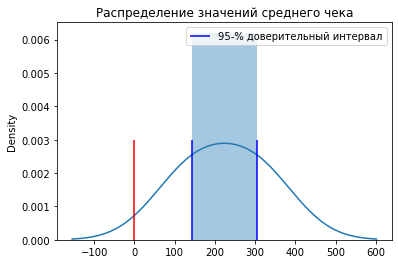

In [42]:
sns.distplot (borders)
plt.title ('Распределение значений среднего чека')
plt.vlines (0,
           ymin = 0,
           ymax = 0.003,
           colors = 'red')
plt.vlines (borders,
           ymin = 0,
           ymax = 0.003,
           colors = 'b',
           label = '95-% доверительный интервал')
plt.legend()




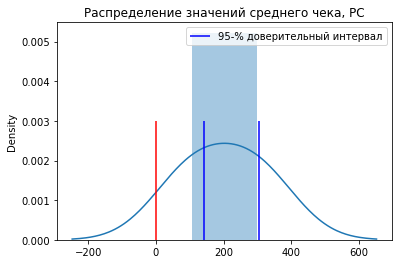

In [43]:
sns.distplot (borders_pc)
plt.title ('Распределение значений среднего чека, PC')
plt.vlines (0,
           ymin = 0,
           ymax = 0.003,
           colors = 'red')
plt.vlines (borders,
           ymin = 0,
           ymax = 0.003,
           colors = 'b',
           label = '95-% доверительный интервал')
plt.legend()


<function matplotlib.pyplot.legend(*args, **kwargs)>

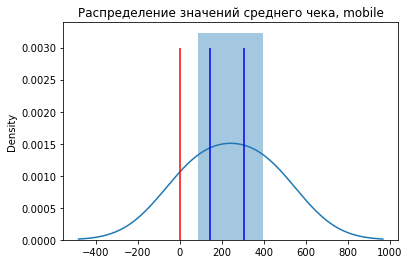

In [44]:
sns.distplot (borders_mobile)
plt.title ('Распределение значений среднего чека, mobile')
plt.vlines (0,
           ymin = 0,
           ymax = 0.003,
           colors = 'red')
plt.vlines (borders,
           ymin = 0,
           ymax = 0.003,
           colors = 'b',
           label = '95-% доверительный интервал')
plt.legend


## Есть значимое влиянеие результатов теста на значение среднего чека. Гипотеза подтверждается.